## Workshop - Bootstrap

Today we will

1. Show the average unique number of observations when bootstrapping
2. Estimate the standard deviation on the causal effect from a **RANDOMIZED CONTROL TRIAL**

**************************************
# Bootstrap Samples

In one code cell:

- import `numpy` and `numpy.random`
- set the seed to 490
- create *a range* from 0 to 10,000
    - *hint: start with a smaller size to set up the framework*
- create an empty list
- in a 1,000 iteration for loop
    - *hint: start with a smaller size to set up the framework*
    - randomly sample your range your range with replacement with a size equal to the length of your range using `npr.choice()`
    - append your empty list with the length of the the number of unique values from the sampling with replacement
- output the average number of unique values over all bootstrapped samples

In [45]:
import numpy as np
import numpy.random as npr
from tqdm import tqdm
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [14]:
npr.seed(490)
r_1 = range(10000)
ls = []
for i in tqdm(range(1000)):
    sample = npr.choice(r_1, len(r_1))
    ls.append(len(np.unique(sample)))

100%|██████████| 1000/1000 [00:01<00:00, 586.20it/s]


In [16]:
np.mean(ls)/len(r_1)

0.6321646

Is this closer to 1/2, 2/3, or 3/4?

2/3

**************
# Randomize Control Trial 

In economics, we call experiments with randomly assigned treatment and control groups __*randomized control trials*__. 
In data science, they are called _**A-B testing**_.

In this application, we will be using a data set from [kaggle](https://www.kaggle.com/samtyagi/audacity-ab-testing). 
We will be using an LPM to estimate the effect of being in a treament group on clicking *something*.
The data is from Audacity, however, there is no information about the experiment specifically. 
We do not know if this is showing different versions of a website, different versions of an advertisement, or something else entirely.



In [17]:
import pandas as pd
from tqdm import tqdm

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt

Load in the audacity data as `ab` with `index_col = timestamp`.
Print the head.

In [18]:
ab = pd.read_csv('homepage_actions.csv', index_col = 'timestamp')
ab.head()

,id,group,action
timestamp,,,
2016-09-24 17:42:27.839496,804196,experiment,view
2016-09-24 19:19:03.542569,434745,experiment,view
2016-09-24 19:36:00.944135,507599,experiment,view
2016-09-24 19:59:02.646620,671993,control,view
2016-09-24 20:26:14.466886,536734,experiment,view


Determine the unique values of `group` and `action`

In [19]:
print(ab['group'].unique())
print(ab['action'].unique())

['experiment' 'control']
['view' 'click']


Create a dummy variable `treatment` for those in the treatment group.
Create a dummy variable `click` for those that clicked.

In [22]:
ab['treatment'] = (ab['group'] == "experiment")*1
ab['click'] = (ab['action'] == "click")*1

In [23]:
ab.head()

,id,group,action,treatment,click
timestamp,,,,,
2016-09-24 17:42:27.839496,804196,experiment,view,1,0
2016-09-24 19:19:03.542569,434745,experiment,view,1,0
2016-09-24 19:36:00.944135,507599,experiment,view,1,0
2016-09-24 19:59:02.646620,671993,control,view,0,0
2016-09-24 20:26:14.466886,536734,experiment,view,1,0


Create an object `x` that is the model matrix composed of a constant and the `treatment` variable.
Create an object `y` that is the `click` variable.

In [25]:
x = sm.add_constant(ab['treatment'])
y = ab['click']

In one line, fit a statsmodel OLS and print the summary. 
Note the estimate and standard error on the `treatment` variable.

In [28]:
sm.OLS(y, x).fit().summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.000    
Dependent Variable: click            AIC:                8991.4917
Date:               2021-03-10 15:38 BIC:                9005.5126
No. Observations:   8188             Log-Likelihood:     -4493.7  
Df Model:           1                F-statistic:        3.738    
Df Residuals:       8186             Prob (F-statistic): 0.0532   
R-squared:          0.000            Scale:              0.17552  
--------------------------------------------------------------------
             Coef.    Std.Err.      t      P>|t|     [0.025   0.975]
--------------------------------------------------------------------
const        0.2186     0.0064   34.0676   0.0000    0.2060   0.2312
treatment    0.0179     0.0093    1.9335   0.0532   -0.0002   0.0361
------------------------------------------------------------------
Omnibus:             1459.439      Durbin-Watson:         2.566   
Prob(Omnibus):       0.000         Jarque-Bera (JB):      2342.875
Skew:                1.301         Prob(JB):              0.000   
Kurtosis:            2.696         Condition No.:         3       
==================================================================

"""

Here we will perform the bootstrap in one code cell.

- set the `npr` seed to 490
- define `n` equal to the number of rows of `ab`
- create an empty list `beta`
- set up a for loop over 2,000 iterations using tqdm
    - use `npr.choice()` to obtain the bootstrap index
    - fit a `LinearRegression()`
        - *hint:* `X` *needs to be a DataFrame, not a Series. Select the* `treatment` *variable using* `ab[['treatment']].iloc[indx]`. `y` *needs to be a Series. Select with only single square brackets.*
    - append the `fit.coef_` to beta
        - *Note: the intercept, which we do not need, is contained seperately in* `fit.intercept_`.

In [39]:
npr.seed(490)
n = len(ab)
beta = []
for i in tqdm(range(2000)):
    indx = npr.choice(range(n), n)
    X = ab[['treatment']].iloc[indx]
    y = ab[['click']].iloc[indx]
    fit = LinearRegression().fit(X, y)
    # fit.intercept_
    beta.append(fit.coef_)

100%|██████████| 2000/2000 [00:11<00:00, 177.49it/s]


Using one `print()` statment, print the average `beta` with 3 decimal places and the standard deviation of `beta` with 4 decimal places.

In [40]:
print(round(np.mean(beta),3), round(np.std(beta),3))

0.018 0.009


Up next, we will produce a histogram. However, we need to perform some preprocessing.

Print the top five observations of `beta` using a slice. Note the format.

In [41]:
beta[:5]

[array([[0.02343743]]),
 array([[0.02741371]]),
 array([[0.00896696]]),
 array([[0.02451603]]),
 array([[0.0079953]])]

To convert to a list we can work with

- use `np.concatenate()` on `beta`
- chain the `.flat` attribute
- wrap the whole thing with `list()`
- overwrite `beta`

In [44]:
beta = list(np.concatenate(beta).flat)

Finally, use `matplotlib` to create a histogram of `beta`. 

(array([  1.,  11.,  69., 249., 450., 531., 411., 205.,  60.,  13.]),
 array([-0.01723765, -0.01079442, -0.00435119,  0.00209204,  0.00853527,
         0.01497851,  0.02142174,  0.02786497,  0.0343082 ,  0.04075143,
         0.04719467]),
 <BarContainer object of 10 artists>)

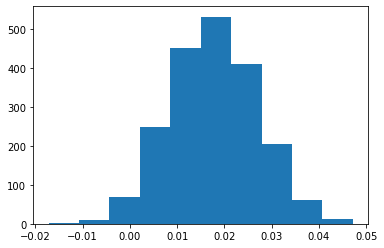

In [46]:
plt.hist(beta)